In [1]:
import re
import math
import pandas as pd
import numpy as np
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import preprocessing

In [24]:
# chargement du dataset
df_cheese = pd.read_csv("Data/cheese_clean.csv", index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [16]:
pd.set_option('display.max_columns', 184)
pd.set_option('display.max_rows', 184)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_seq_items', 184)
pd.set_option('display.width', 100)

## fonctions a utiliser

In [4]:
def histplot(cols, log=False):
    '''
    faire plusieurs histrograme dans un bloc
    '''
    plt.figure(figsize=(30,20))
    for i, col in enumerate(cols):
        plt.subplot(3, 3, i+1)
        plt.hist(df_cheese[col], bins=100)
        plt.xlabel(col)
        if log:
            plt.yscale('log')

In [5]:
def topCorrel(df, seuil):
    '''
    liste des plus au moins correlé les variables
    '''
    liste_top = pd.Series()
    correl = df.corr()
    for iind, i in enumerate(correl.columns):
        for rind, r in enumerate(correl.index):
            if iind < rind:
                if abs(correl.loc[i,r]) >= seuil:
                    liste_top[i+ ' - '+r] = correl.loc[i,r]
            else:
                pass
    return liste_top.sort_values(ascending=False)

In [6]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [7]:
from matplotlib.collections import LineCollection
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(15,15))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

## Analyse univariée

### distribution du nutriscore et de l'ecoscore
à savoir, le nutriscore et l'ecoscore sont un indice qui, plus il crois, moins son score est "bon"
(plus le score est faible, meilleurs est la qualitée du produit)

<AxesSubplot:xlabel='ecoscore_score_fr', ylabel='Density'>

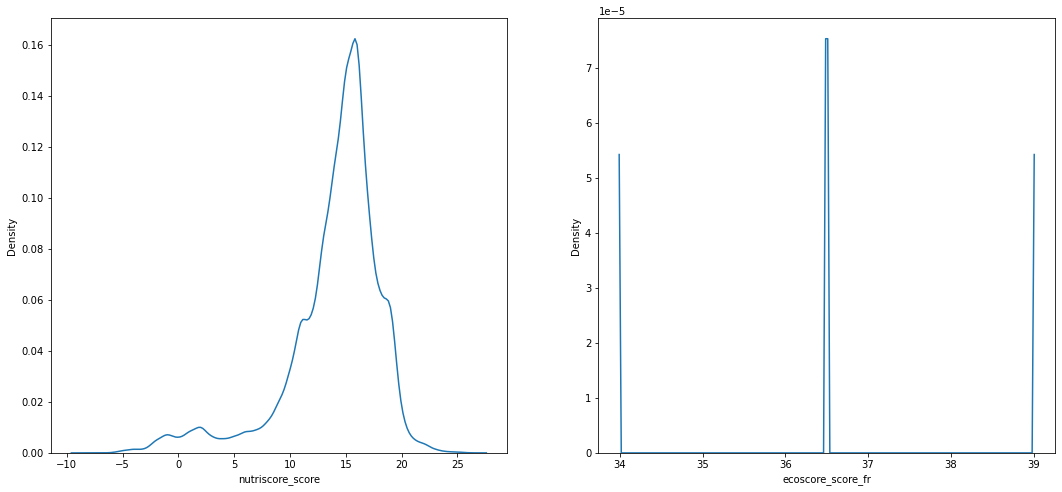

In [17]:
plt.figure(figsize=(18,8))
plt.subplot(121)
sns.kdeplot(df_cheese['nutriscore_score'])
plt.subplot(122)
sns.kdeplot(df_cheese['ecoscore_score_fr'])

#### répartition du nova group
le nova group est l'indice de "transformation" du produit, plus l'indice est grand, plus le produit est transformé.
on constate ici que les produit sont également répartie entre le groupe 3 et 4

<AxesSubplot:ylabel='nova_group'>

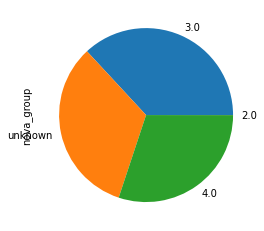

In [14]:
df_cheese['nova_group'].value_counts().plot.pie()

#### distribution des nutriments et apport energetique

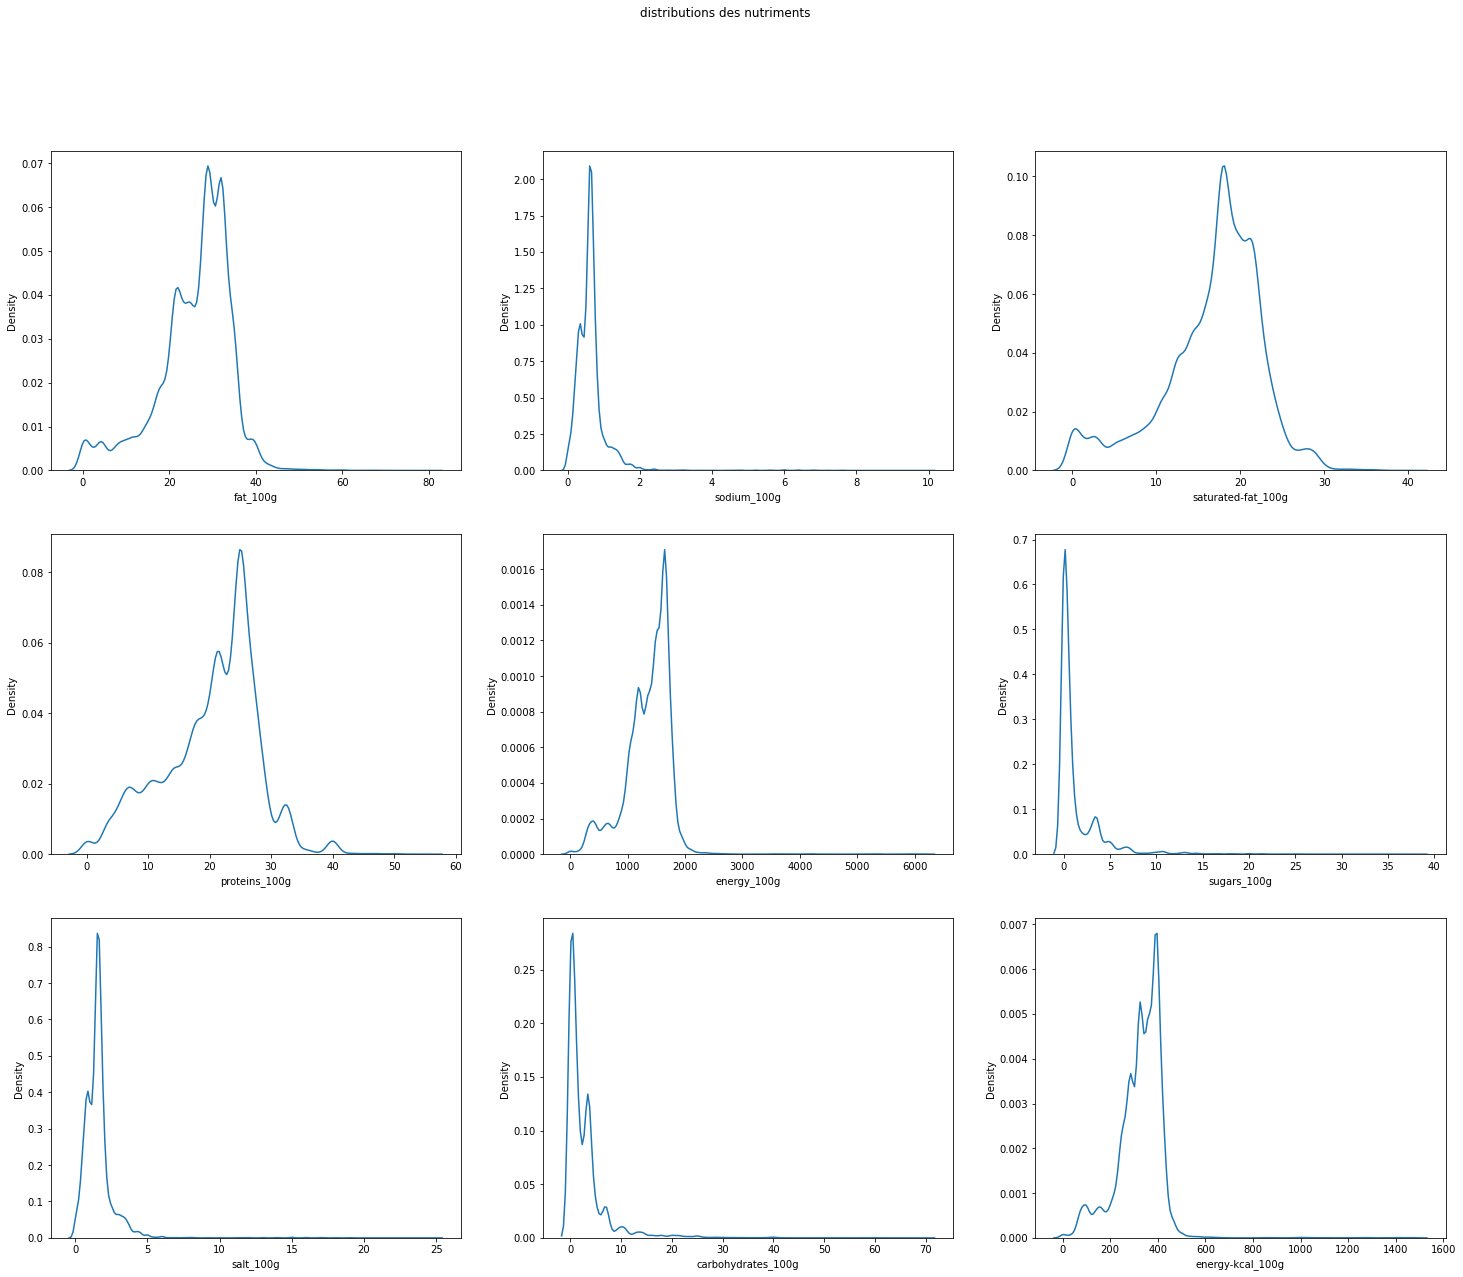

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(25,20))
nutri = ['fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'sugars_100g', 'energy-kcal_100g']
fig.suptitle('distributions des nutriments')
plot_index = 0
for i in range(3):
    for r in range(3):
        sns.kdeplot(df_cheese[nutri[plot_index]], ax=axes[r, i])
        plot_index += 1

### Matrice de corrélation
- la première heatmap montre la correlation de tout le tableau
- la dexieme heatmap ne garde que les variables qui ont un indice de correlation absolut superieur à 40%, et ne montre que ces indice en questions

<AxesSubplot:>

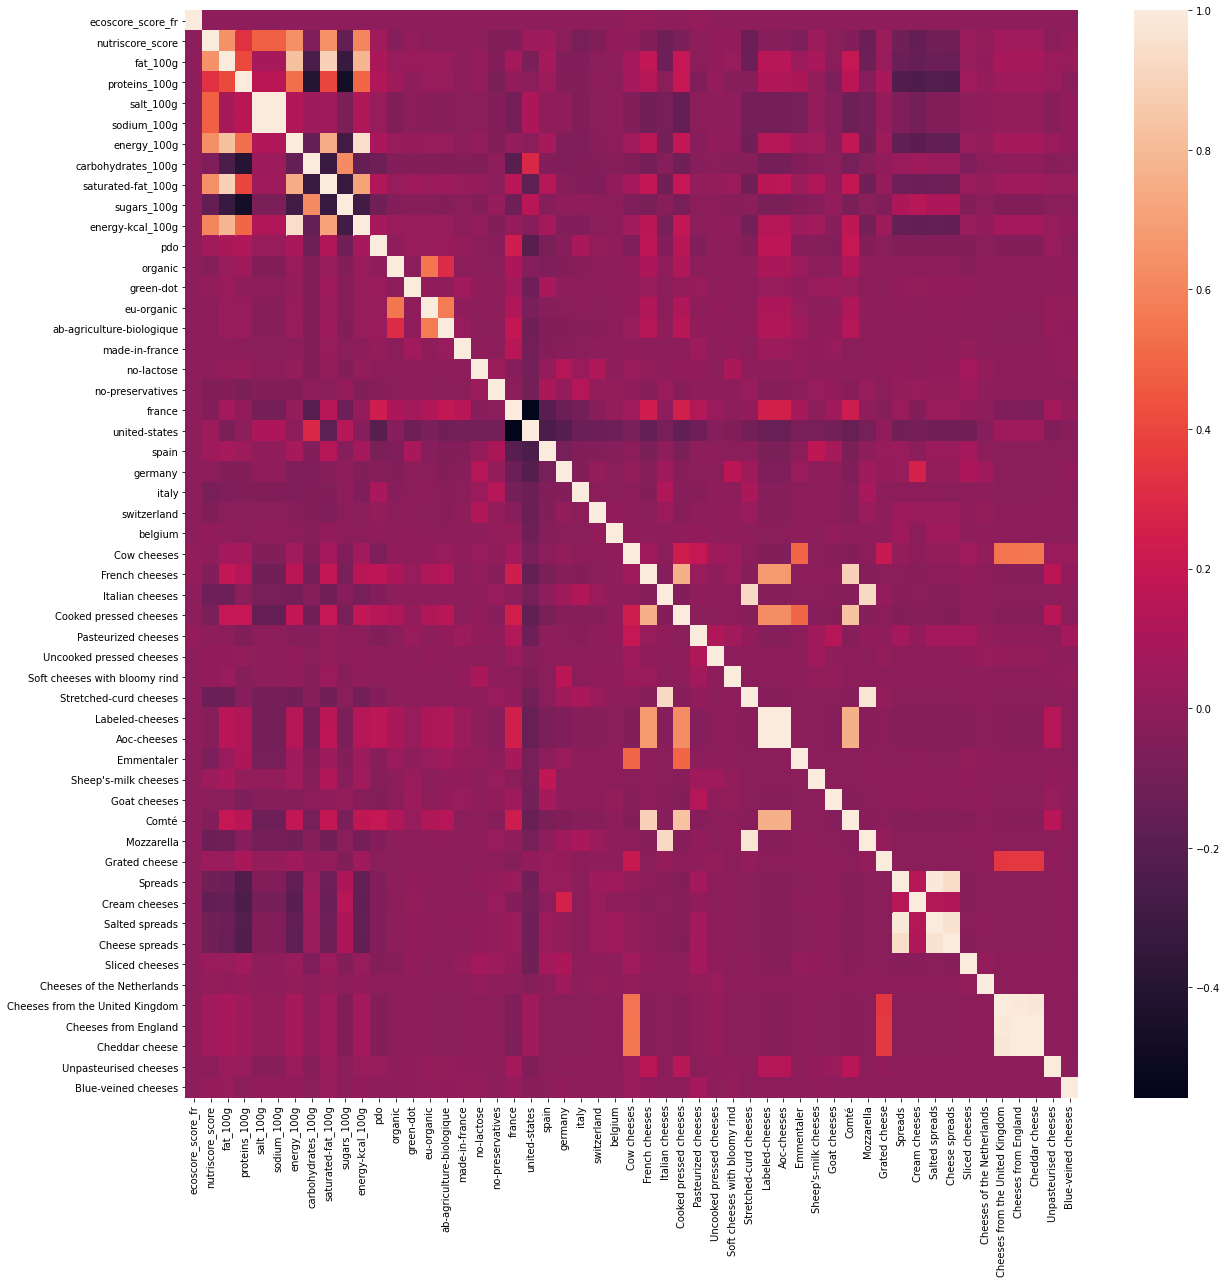

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(df_cheese.drop(['created_year', 'brands', 'ingredients_text'], axis=1).corr())

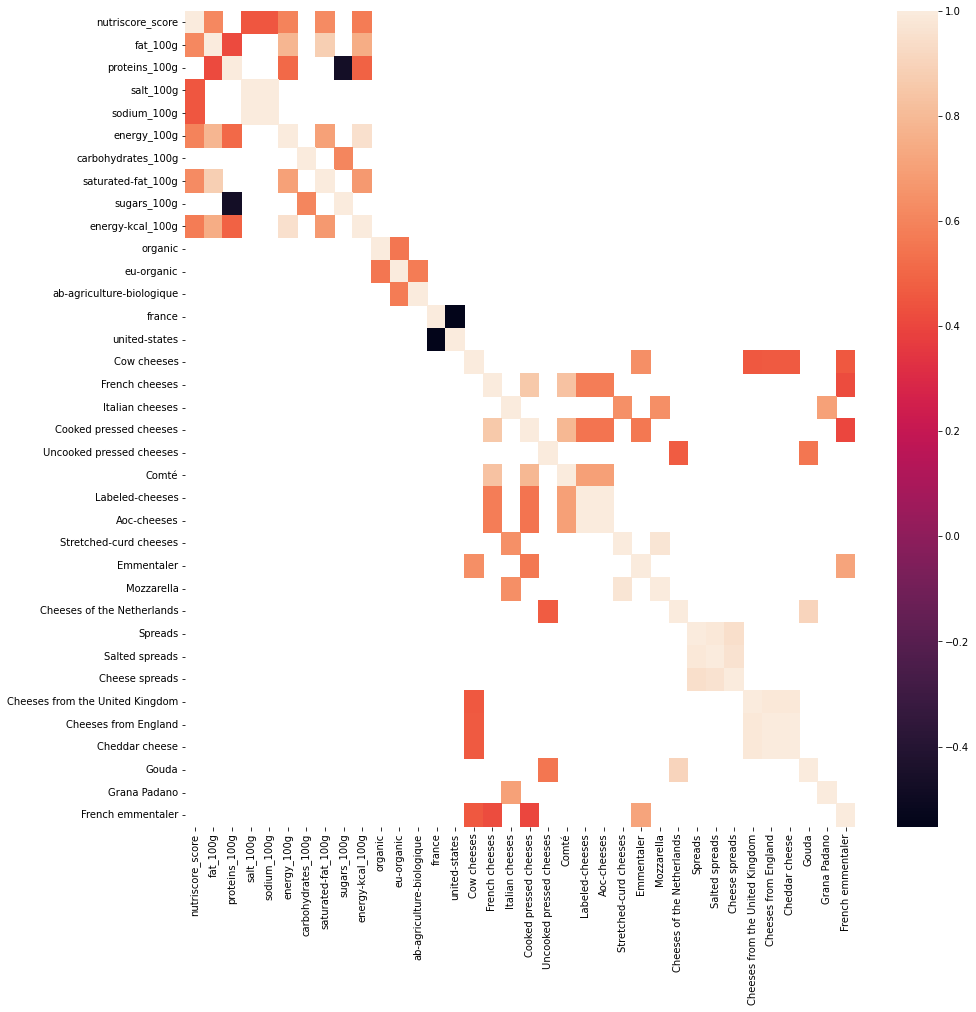

In [46]:
true_corr = df_cheese.drop(['main_category_en', 'created_year', 'brands', 'ingredients_text'], axis=1)
correl = true_corr.corr()
liste_seuil = correl[correl.abs() > 0.4].sum()
for i in true_corr.columns:
    if liste_seuil[i] == 1:
        true_corr.drop(i, axis=1, inplace=True)
plt.figure(figsize=(15,15))
sns.heatmap(true_corr.corr()[true_corr.corr().abs() > 0.4])

In [45]:
true_corr = df_cheese.drop(['main_category_en', 'created_year', 'brands', 'ingredients_text'], axis=1)
liste_correl = topCorrel(true_corr, 0.4)
print(liste_correl)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


salt_100g - sodium_100g                                   1.000000
Labeled-cheeses - Aoc-cheeses                             0.999170
Cheeses from England - Cheddar cheese                     0.997526
Spreads - Salted spreads                                  0.985295
Cheeses from the United Kingdom - Cheeses from England    0.984608
Cheeses from the United Kingdom - Cheddar cheese          0.982156
Stretched-curd cheeses - Mozzarella                       0.975622
Salted spreads - Cheese spreads                           0.961201
energy_100g - energy-kcal_100g                            0.955323
Spreads - Cheese spreads                                  0.946970
Cheeses of the Netherlands - Gouda                        0.906236
fat_100g - saturated-fat_100g                             0.880965
French cheeses - Cooked pressed cheeses                   0.854724
French cheeses - Comté                                    0.830237
Cooked pressed cheeses - Comté                            0.78

### ACP

In [15]:
df_acp = df_cheese.drop(['main_category_en', 'created_year', 'brands', 'ingredients_text', 'nova_group'], axis=1)
X = df_acp.values
features = df_acp.columns

In [20]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [26]:
n_comp = 40
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=40)

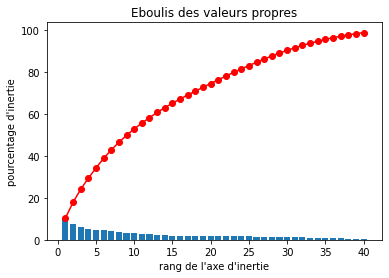

In [27]:
display_scree_plot(pca)

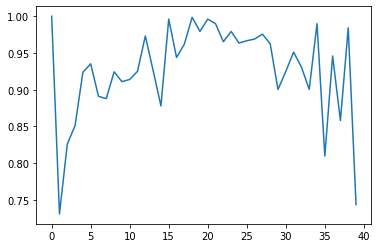

In [36]:
crois = pca.explained_variance_ratio_*100
raport = []
indice = crois[0]
for i in crois:
    raport.append(i/indice)
    indice = i
plt.plot(range(len(raport)), raport)

In [40]:
crois[:14]

array([10.28264662,  7.5156194 ,  6.20660969,  5.28322924,  4.88018684,
        4.56415036,  4.06617859,  3.61040809,  3.33698543,  3.03990346,
        2.77822407,  2.56994289,  2.50094493,  2.31645845])

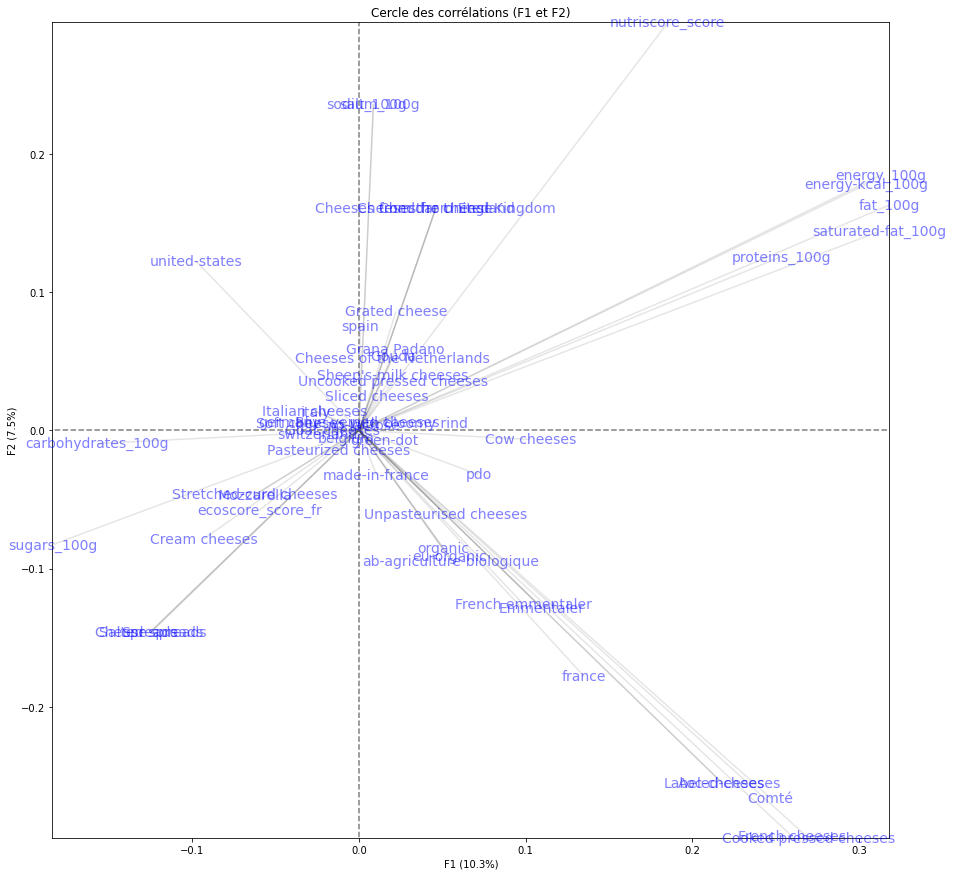

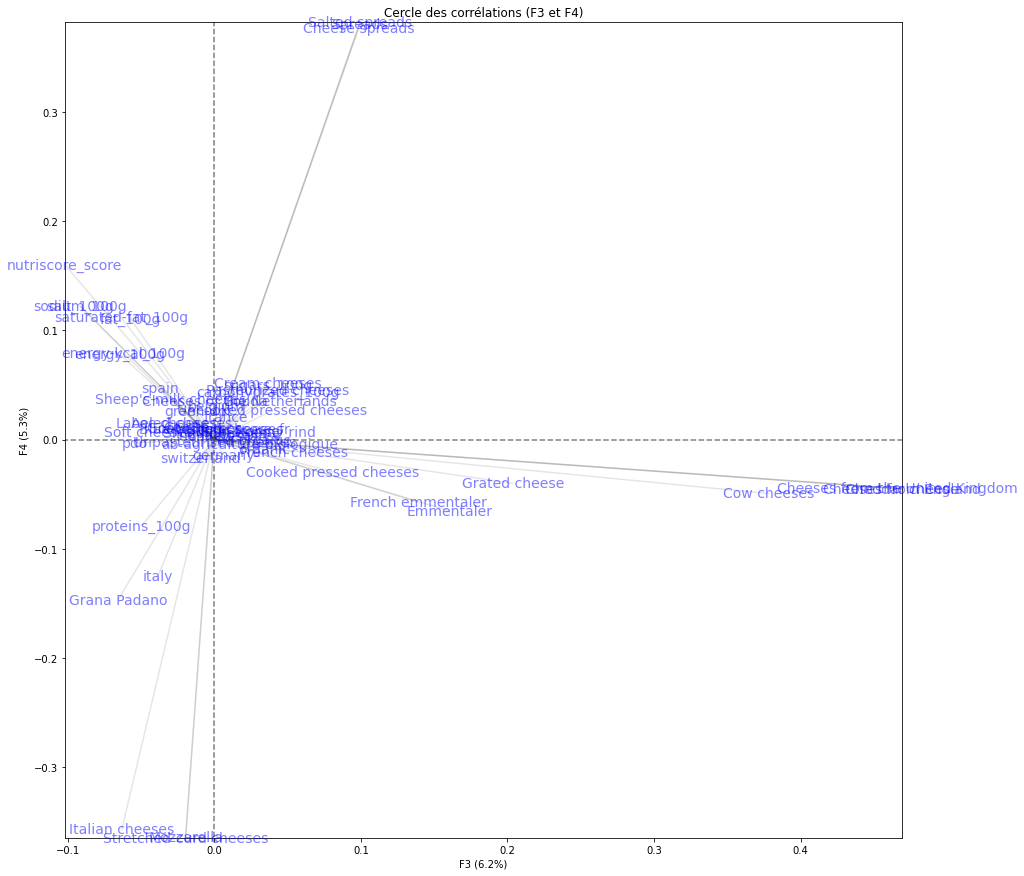

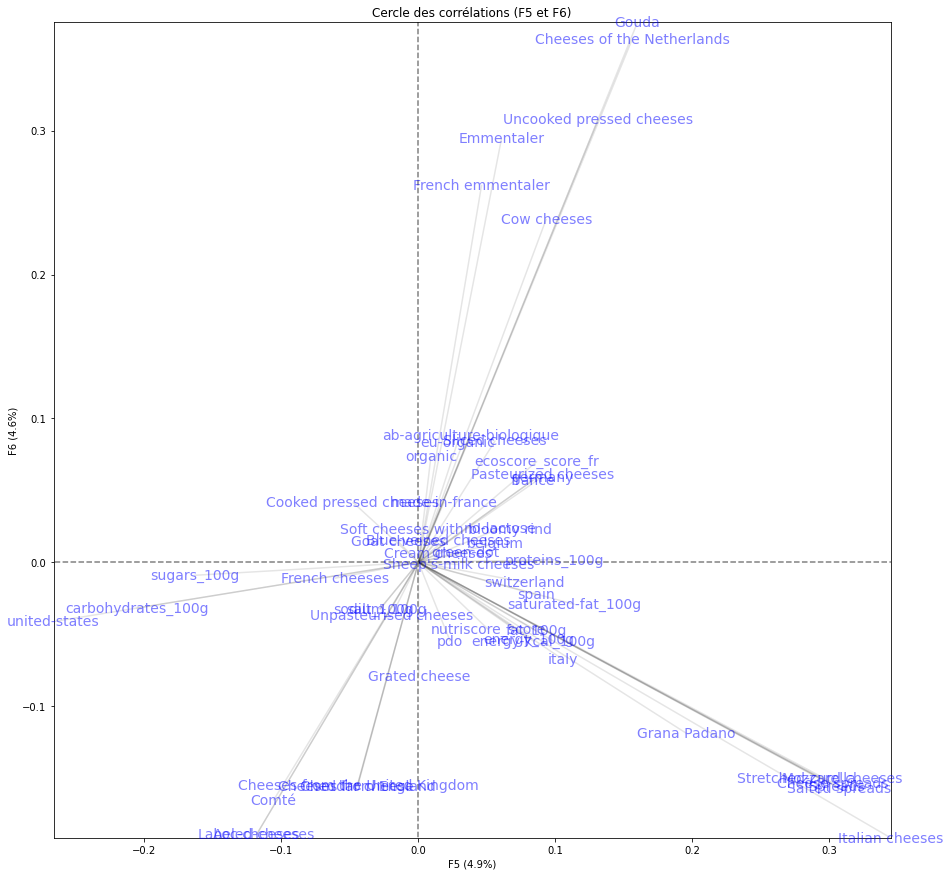

In [48]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

## avancement actuel

In [207]:
df_cheese[['Comté', 'Emmentaler', 'Mozzarella', 'Cheddar cheese', 'Gouda']].sum(axis=1).value_counts()

0    37004
1     5158
dtype: int64

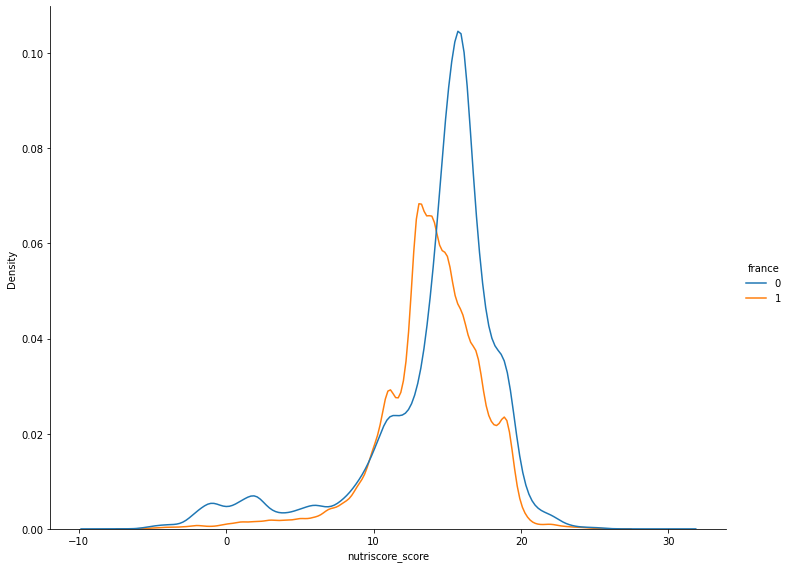

la moyenne du nutriscore pour la france 13.9 et pour les autres pays 14.1


In [46]:
sns.displot(data=df_cheese, x="nutriscore_score", hue="france", kind="kde", height=8, aspect=1.3)
plt.show()
print('la moyenne du nutriscore pour la france : ' + str(df_cheese[df_cheese['france'] == 1]['nutriscore_score'].mean())[:4] + ' et pour les autres pays : ' + str(df_cheese[df_cheese['france'] == 0]['nutriscore_score'].mean())[:4])

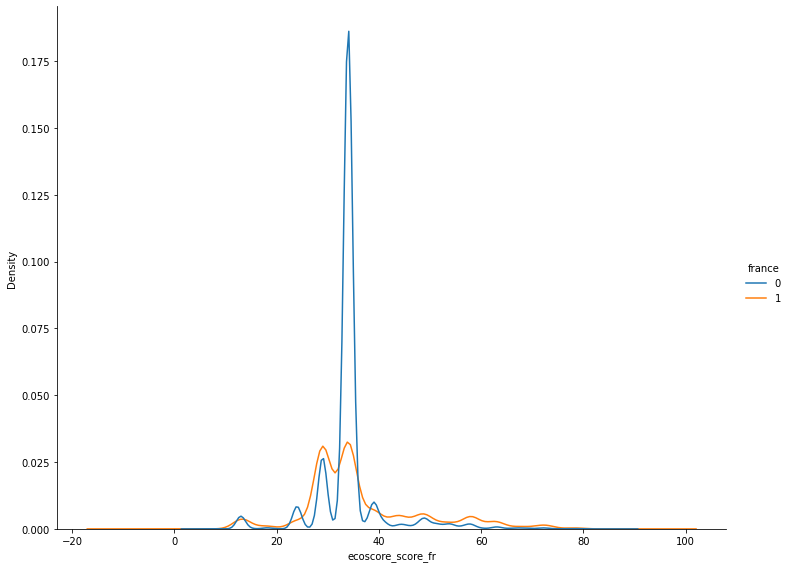

la moyenne du nutriscore pour la france : 36.3 et pour les autres pays : 34.2


In [47]:
sns.displot(data=df_cheese, x="ecoscore_score_fr", hue="france", kind="kde", height=8, aspect=1.3)
plt.show()
print('la moyenne du nutriscore pour la france : ' + str(df_cheese[df_cheese['france'] == 1]['ecoscore_score_fr'].mean())[:4] + ' et pour les autres pays : ' + str(df_cheese[df_cheese['france'] == 0]['ecoscore_score_fr'].mean())[:4])

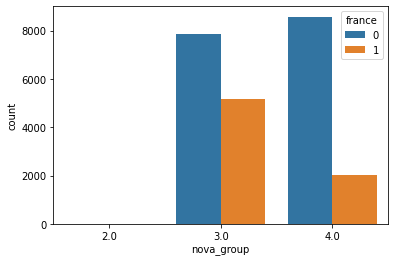

In [50]:
sns.countplot(data=df_cheese, x='nova_group', hue='france')

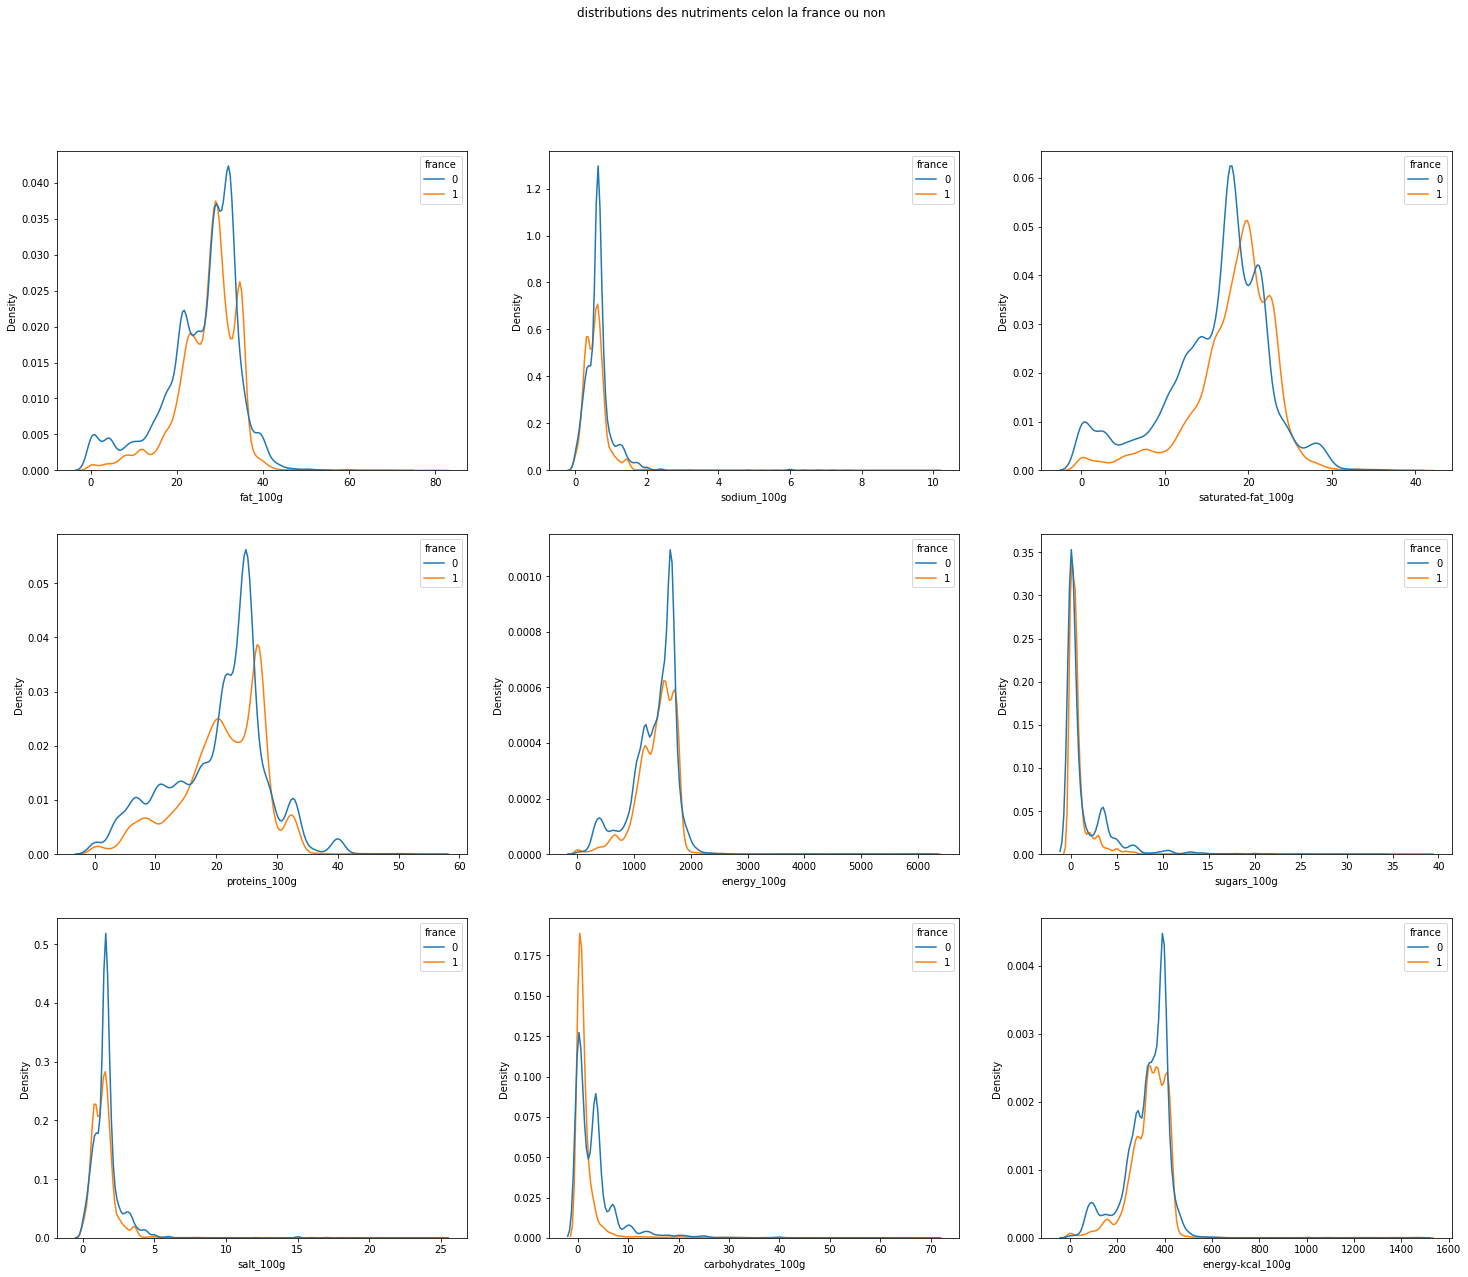

In [104]:
fig, axes = plt.subplots(3, 3, figsize=(25,20))
nutri = ['fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'sugars_100g', 'energy-kcal_100g']
fig.suptitle('distributions des nutriments celon la france ou non')
plot_index = 0
for i in range(3):
    for r in range(3):
        sns.kdeplot(data=df_cheese,x=nutri[plot_index],hue='france', ax=axes[r, i])
        plot_index += 1

In [78]:
print('la moyenne du gras saturé pour la france : ' + str(df_cheese[df_cheese['france'] == 1]['saturated-fat_100g'].mean())[:4] + ' et pour les autres pays : ' + str(df_cheese[df_cheese['france'] == 0]['saturated-fat_100g'].mean())[:4] + ' pour 100g')

la moyenne du gras saturé pour la france : 18.2 et pour les autres pays : 16.1 pour 100g


In [105]:
df_cheese.corr()['nova_group'].sort_values()

proteins_100g                     -0.275060
france                            -0.223513
saturated-fat_100g                -0.191225
ecoscore_score_fr                 -0.163663
pdo                               -0.156120
Cooked pressed cheeses            -0.149914
energy_100g                       -0.140937
energy-kcal_100g                  -0.135874
fat_100g                          -0.134783
Italian cheeses                   -0.123804
French cheeses                    -0.122393
Stretched-curd cheeses            -0.106184
Comté                             -0.105929
Mozzarella                        -0.104526
ab-agriculture-biologique         -0.097998
Emmentaler                        -0.097741
Goat cheeses                      -0.077352
germany                           -0.072498
Labeled-cheeses                   -0.070990
Aoc-cheeses                       -0.070779
French emmentaler                 -0.067590
Grana Padano                      -0.065125
organic                         

In [60]:
df_cheese.corr()['france'].sort_values()

united-states                     -0.552379
created_year                      -0.253002
spain                             -0.238819
nova_group                        -0.223513
carbohydrates_100g                -0.202859
germany                           -0.149610
italy                             -0.138403
sugars_100g                       -0.132692
sodium_100g                       -0.084244
salt_100g                         -0.084243
switzerland                       -0.064035
Cheddar cheese                    -0.060539
Cheeses from England              -0.060508
Cheeses from the United Kingdom   -0.059575
Cream cheeses                     -0.050017
Grana Padano                      -0.048928
Italian cheeses                   -0.044499
Grated cheese                     -0.038860
no-lactose                        -0.035613
nutriscore_score                  -0.025022
Sheep's-milk cheeses              -0.019651
Gouda                             -0.014470
belgium                         

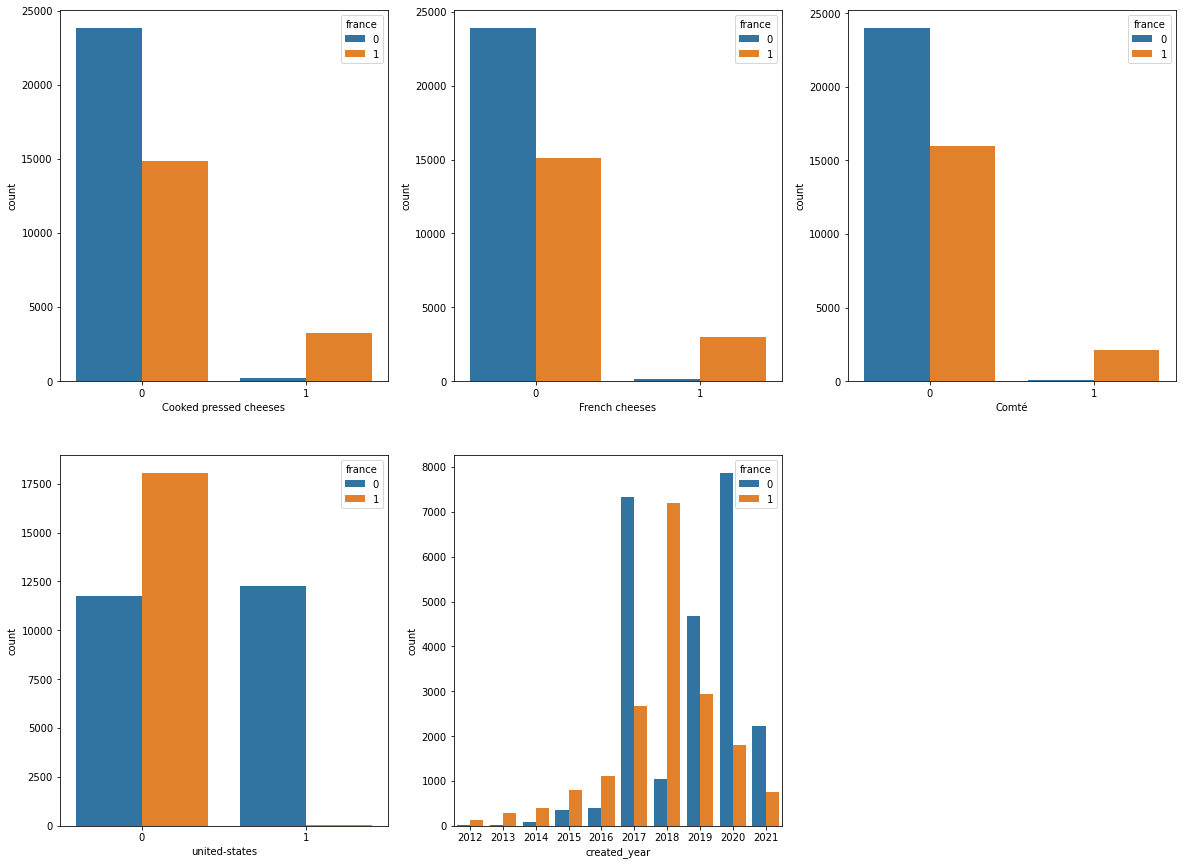

In [74]:
plt.figure(figsize=(20,15))
plt.subplot(231)
sns.countplot(data=df_cheese, x='Cooked pressed cheeses', hue='france')
plt.subplot(232)
sns.countplot(data=df_cheese, x='French cheeses', hue='france')
plt.subplot(233)
sns.countplot(data=df_cheese, x='Comté', hue='france')
plt.subplot(234)
sns.countplot(data=df_cheese, x='united-states', hue='france')
plt.subplot(235)
sns.countplot(data=df_cheese, x='created_year', hue='france')